__<span style="background-color:#ffffe0">第3章　時系列予測モデル構築・超入門</span>__

# 3.4　季節成分が複数ある場合の予測モデル

##  3.4.5　線形回帰で構築する予測モデル

### 準備（必要なモジュールとデータの読み込み）

In [1]:
#
# 必要なモジュールの読み込み
#

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from pmdarima.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定
plt.rcParams['font.size'] = 14 #フォントサイズ

In [2]:
#
# 必要なデータセット（時系列データ）の読み込み
#

df=pd.read_csv('taylor_tbl_.csv') 

print(df) #確認

          y     lag1      window48     expanding  sin336_1  cos336_1   
0     25093  26572.0  31398.145833  31398.145833  0.781831  0.623490  \
1     24320  25093.0  31457.125000  31269.469388  0.793353  0.608761   
2     24684  24320.0  31510.541667  31130.480000  0.804598  0.593820   
3     25338  24684.0  31561.312500  31004.078431  0.815561  0.578671   
4     24943  25338.0  31615.041667  30895.115385  0.826239  0.563320   
...     ...      ...           ...           ...       ...       ...   
3979  27946  28677.0  25060.208333  29621.921033 -0.093364  0.995632   
3980  27133  27946.0  25046.520833  29621.504965 -0.074730  0.997204   
3981  25996  27133.0  25034.812500  29620.887317 -0.056070  0.998427   
3982  24610  25996.0  25019.125000  29619.987841 -0.037391  0.999301   
3983  23132  24610.0  25003.041667  29618.744976 -0.018699  0.999825   

      sin336_2  cos336_2  sin336_3  cos336_3  ...       sin48_6       cos48_6   
0     0.974928 -0.222521  0.433884 -0.900969  ... -1.4

In [3]:
#
# データセットを学習データとテストデータ（直近12ヶ月間）に分割
#

# データ分割
## 目的変数
y_train, y_test = train_test_split(
    df.y, test_size=336)

## 説明変数
X_train, X_test = train_test_split(
    df.drop('y', axis=1), test_size=336)

### 予測モデルの学習（学習データ利用）

In [4]:
#
# 予測モデルの学習（学習データ利用）
#

# 数理モデルのインスタンス生成
regressor = LinearRegression()

# 学習
regressor.fit(X_train, y_train)

LinearRegression()

### 予測モデルのテスト（テストデータ利用）

In [5]:
#
# 予測の実施（学習データ期間）
#

train_pred = regressor.predict(X_train)

In [6]:
#
# 予測の実施（テストデータ期間）
#

# 学習データのコピー
y_train_new = y_train.copy()

# 説明変数Xを更新しながら予測を実施
for i in range(len(y_test)):
    
    #当期の予測の実施
    X_value =  X_test.iloc[i:(i+1),:]
    y_value_pred = regressor.predict(X_value)
    y_value_pred = pd.Series(y_value_pred,index=[X_value.index[0]])
    y_train_new = pd.concat([y_train_new,y_value_pred])
    
    #次期の説明変数Xの計算
    lag1_new = y_train_new.iloc[-1] #lag1
    window48_new = y_train_new[-48:].mean() #window48
    expanding_new = y_train_new.mean() #expanding
    
    #次期の説明変数Xの更新
    X_test.iloc[(i+1):(i+2),0] = lag1_new
    X_test.iloc[(i+1):(i+2),1] = window48_new
    X_test.iloc[(i+1):(i+2),2] = expanding_new
    
# 予測値の代入
test_pred = y_train_new[-336:]
    
# 更新後の説明変数X
print(X_test)

              lag1      window48     expanding      sin336_1  cos336_1   
3648  23835.000000  25416.625000  29589.356602  4.411204e-15  1.000000  \
3649  22631.537908  25411.677873  29563.656492  1.869887e-02  0.999825   
3650  22088.896027  25409.321540  29561.608612  3.739119e-02  0.999301   
3651  22033.269098  25414.056313  29559.546618  5.607045e-02  0.998427   
3652  22098.985207  25426.889338  29557.503748  7.473009e-02  0.997204   
...            ...           ...           ...           ...       ...   
3979  27725.119344  25218.361321  29578.910944 -9.336361e-02  0.995632   
3980  28132.490719  25213.068539  29578.547522 -7.473009e-02  0.997204   
3981  27907.315377  25207.271223  29578.127720 -5.607045e-02  0.998427   
3982  26850.540584  25201.470019  29577.442741 -3.739119e-02  0.999301   
3983  25218.852858  25196.301847  29576.348443 -1.869887e-02  0.999825   

          sin336_2  cos336_2      sin336_3  cos336_3      sin336_4  ...   
3648  8.822409e-15  1.000000 -2.9398

In [7]:
#
# 予測モデルのテスト（テストデータ利用）
#

print('RMSE:\n',
      np.sqrt(mean_squared_error(
          y_test, test_pred)))
print('MAE:\n',
      mean_absolute_error(
          y_test, test_pred)) 
print('MAPE:\n',
      mean_absolute_percentage_error(
          y_test, test_pred))

RMSE:
 910.856997270633
MAE:
 630.9205452449072
MAPE:
 0.02186569513400616


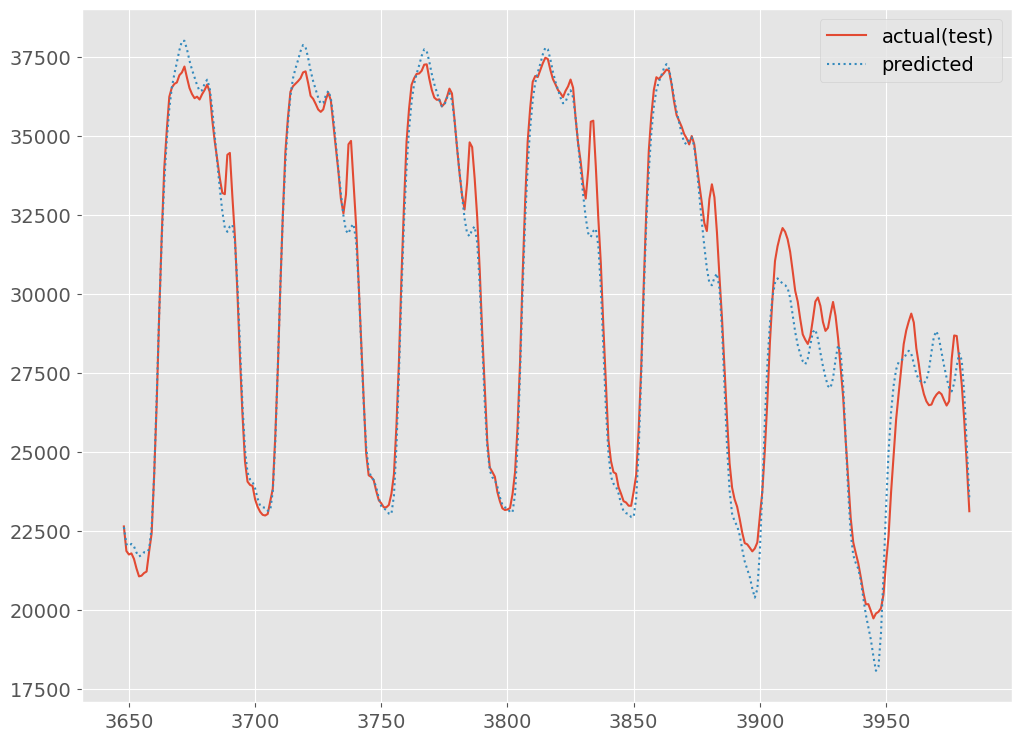

In [8]:
#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値
ax.plot(
    y_test.index, 
    y_test.values, 
    linestyle='-',
    label='actual(test)')

# 予測値
ax.plot(
    y_test.index, 
    test_pred, 
    linestyle=':',
    label="predicted") 

# 凡例表示
ax.legend()

plt.show()

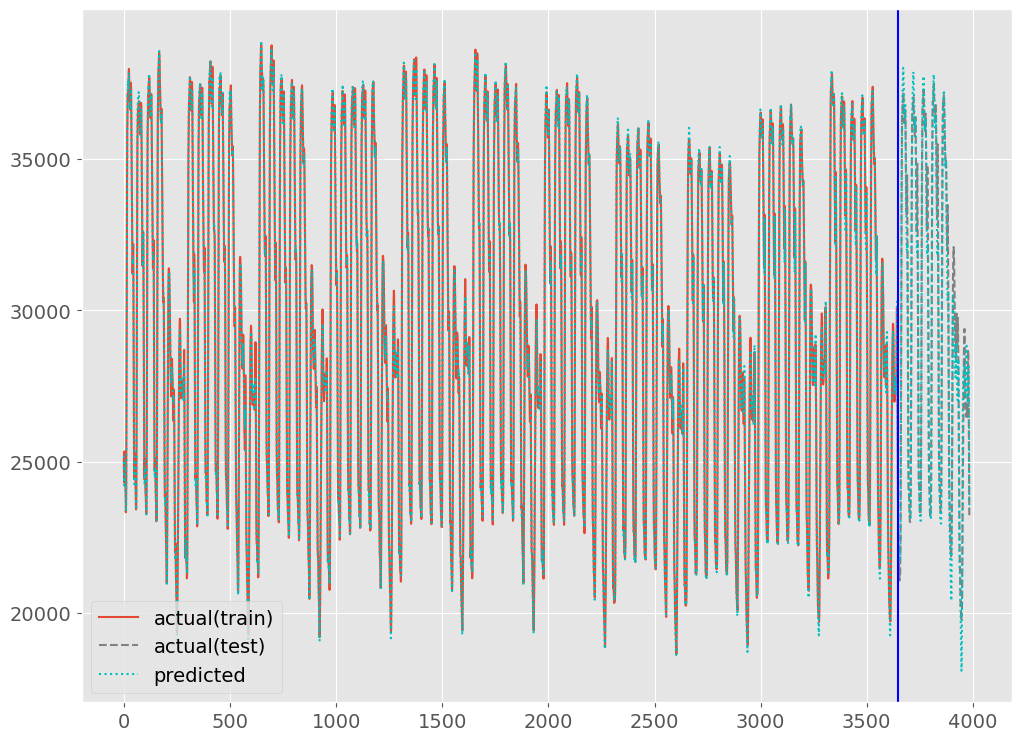

In [9]:
#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値の描写
## 学習データ
ax.plot(
    y_train.index,
    y_train.values, 
    linestyle='-',
    label='actual(train)')

## テストデータ
ax.plot(
    y_test.index, 
    y_test.values,
    linestyle='--',
    label='actual(test)',
    color='gray')

# 予測値の描写
## 学習データ
ax.plot(
    y_train.index,
    train_pred, 
    linestyle=':',
    color='c')

## テストデータ
ax.plot(
    y_test.index,
    test_pred,
    linestyle=':',
    label="predicted",
    color='c') 

# 学習データとテスデータの間の縦線の描写
ax.axvline(
    len(y_train),
    color='blue')

# 凡例表示
ax.legend()

plt.show()